In [1]:
import gpytorch
import matplotlib.pyplot as plt
import torch
from func_data_generation import *
from func_polygon import *
from torch import nn
from utils import *
from warp_units import *

# from torchsummary import summary


dtype = torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
# device =  "cpu"
print("Using {} device".format(device))

import tqdm

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

Using cuda device


In [2]:
class ScaleToBounds(torch.nn.Module):
    """
    Scale the input data so that it lies in between the lower and upper bounds.

    In training (`self.train()`), this module adjusts the scaling factor to the minibatch of data.
    During evaluation (`self.eval()`), this module uses the scaling factor from the previous minibatch of data.

    :param float lower_bound: lower bound of scaled data
    :param float upper_bound: upper bound of scaled data

    Example:
        >>> train_x = torch.randn(10, 5)
        >>> module = gpytorch.utils.grid.ScaleToBounds(lower_bound=-1., upper_bound=1.)
        >>>
        >>> module.train()
        >>> scaled_train_x = module(train_x)  # Data should be between -0.95 and 0.95
        >>>
        >>> module.eval()
        >>> test_x = torch.randn(10, 5)
        >>> scaled_test_x = module(test_x)  # Scaling is based on train_x
    """

    def __init__(self, lower_bound, upper_bound):
        super().__init__()
        self.lower_bound = float(lower_bound)
        self.upper_bound = float(upper_bound)
        self.register_buffer("min_val", torch.tensor(lower_bound))
        self.register_buffer("max_val", torch.tensor(upper_bound))

    def forward(self, x):
        if self.training:
            min_val = x.min()
            max_val = x.max()
            self.min_val.data = min_val
            self.max_val.data = max_val
        else:
            min_val = self.min_val
            max_val = self.max_val
            # Clamp extreme values
            x = x.clamp(min_val, max_val)

        diff = max_val - min_val
        x = (x - min_val) * (
            0.95 * (self.upper_bound - self.lower_bound) / diff
        ) + 0.95 * self.lower_bound
        return x

In [3]:
class WarpModel(torch.nn.Sequential):
    def __init__(self):
        super(WarpModel, self).__init__()
        self.add_module(
            "axial_dim0", AxialWarpUnit(dim=0, res=20, grad=20, lims=[0, 1.0])
        )
        self.add_module(
            "axial_dim1", AxialWarpUnit(dim=1, res=20, grad=20, lims=[-1.0, 0])
        )
        #         self.add_module("rbf_seq1", rbfunit_sequential(res=1, ylim=[-1.0, 0.0]))
        self.add_module("rbf_seq2", rbfunit_sequential(res=2, ylim=[-1.0, 0.0]))

        #         self.add_module("rbf_seq3", rbfunit_sequential(res=3, ylim=[-1, 0]))

        self.add_module("mobius", MobiusWarpUnit())


class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, warp_model):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #         self.covar_module = gpytorch.kernels.SpectralMixtureKernel(
        #             num_mixtures=4, ard_num_dims=2
        #         )
        #         self.covar_module2 = gpytorch.kernels.ScaleKernel(
        #             gpytorch.kernels.PolynomialKernel(1, active_dimes=[0])
        #             * gpytorch.kernels.PolynomialKernel(1, active_dimes=[1])
        #         )
        #         self.covar_module2 = gpytorch.kernels.ScaleKernel(
        #             gpytorch.kernels.PolynomialKernel(power=2)
        #         )
        #         self.covar_module2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.space_transform = warp_model
        self.scale_to_bounds = ScaleToBounds(0, 1)

        #         self.register_parameter(
        #             name="offset", parameter=torch.nn.Parameter(torch.zeros(1, 2))
        #         )

    #         self.w1 = 0.5
    #         self.w2 = 0.5

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        # We're also scaling the features so that they're nice values
        projected_x = self.space_transform(x)
        projected_x = self.scale_to_bounds(projected_x)
        #         projected_x[:, 1] = self.scale_to_bounds_2(projected_x[:, 1])

        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)  # + self.covar_module2(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [7]:
data_num = 2
sensor_num = 200  # [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# load data
coords, shadow, shadow_noise, train_X, train_y, idx = load_data(data_num, sensor_num)

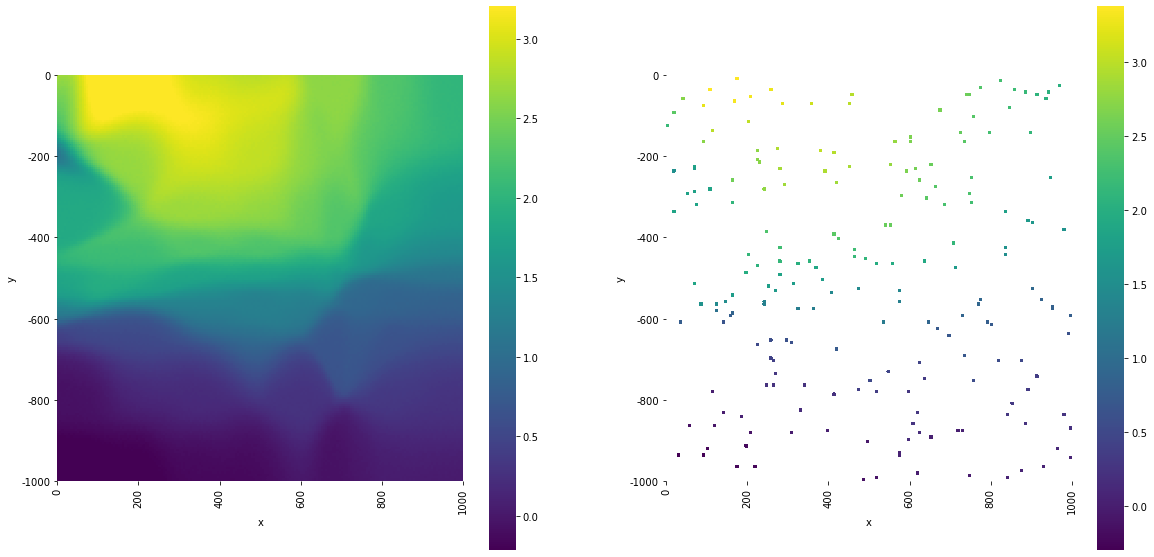

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_heatmap(coords, shadow, ax=axes[0], robust=True, cbar=True)
plot_heatmap(
    coords,
    shadow,
    mask_idx=idx,
    ax=axes[1],
    cbar=True,
)

In [9]:
# Normalize train_X to 0-1
train_X_tensor = torch.from_numpy(train_X).to(device) / 1000
coords_tensor = torch.from_numpy(coords).to(device) / 1000

train_y_tensor = torch.from_numpy(train_y).to(device)
# train_y_mean = train_y_tensor.mean()
# train_y_tensor = train_y_tensor - train_y_mean
# train_y_sigma = torch.sqrt(train_y_tensor.var())
# train_y_tensor = (train_y_tensor - train_y_mean) / train_y_sigma

In [10]:
random_seed = 22
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

warp_model = WarpModel().to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
gp_model = GPRegressionModel(
    train_x=train_X_tensor,
    train_y=train_y_tensor,
    likelihood=likelihood,
    warp_model=warp_model,
).to(device)
gp_model.likelihood.noise = 0.2
gp_model.covar_module.base_kernel.lengthscale = 0.07487
gp_model.covar_module.outputscale = 10

In [11]:
test_model = nn.Sequential()
test_model.add_module("warp_model", warp_model)
test_model.add_module("scal_model_1", gp_model.scale_to_bounds)
# test_model.add_module("scal_model_2", gp_model.scale_to_bounds_2)

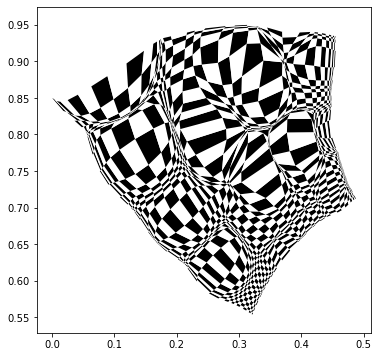

In [12]:
chessboard_from_model(test_model, chessgrid_res=40)

In [13]:
# for name, param in gp_model.named_parameters():
#     print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")

In [14]:
# Use the adam optimizer
optimizer = torch.optim.Adam(
    [
        #         {"params": gp_model.offset, "lr": 0.1},
        {"params": gp_model.space_transform.parameters()},
        {"params": gp_model.covar_module.parameters()},
        #         {"params": gp_model.covar_module2.raw_outputscale},
        #         {"params": gp_model.covar_module2.parameters()},
        #         {"params": gp_model.mean_module.parameters()},
        {"params": gp_model.likelihood.parameters()},
    ],
    lr=0.01,
)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)


def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = gp_model(train_X_tensor)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y_tensor)
        loss.backward()
        if i % 10 == 9:
            writer.add_scalar("loss", loss.item(), i)
            writer.add_scalar(
                "length_scale1", gp_model.covar_module.base_kernel.lengthscale.item(), i
            )
            writer.add_scalar(
                "output_scale1", gp_model.covar_module.outputscale.item(), i
            )
            #             writer.add_scalar(
            #                 "output_scale", gp_model.covar_module2.outputscale.item(), i
            #             )
            #             #             writer.add_scalar("offset0", gp_model.offset[0, 0].item(), i)
            #             #             writer.add_scalar("offset1", gp_model.offset[0, 1].item(), i)
            #             writer.add_scalar(
            #                 "length_scale",
            #                 gp_model.covar_module2.base_kernel.lengthscale.item(),
            #                 i,
            #             )
            writer.add_scalar("noise", gp_model.likelihood.noise.item(), i)

        optimizer.step()

In [15]:
# gp_model.w1 = 0
# gp_model.w2 = 1
# gp_model.w1 = 0.2
# gp_model.w2 = 0.8

gp_model.train()
likelihood.train()

now = datetime.now()
log_dir = "logs/warpgp/" + now.strftime("%Y%m%d-%H%M%S") + "/"
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(log_dir)


training_iterations = 10000
%time train()

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 1h 24min 59s, sys: 43.3 s, total: 1h 25min 42s
Wall time: 9min 18s


In [ ]:
# for name, param in gp_model.named_parameters():
#     print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")

In [17]:
sigma = gp_model.covar_module.outputscale.item()
l = gp_model.covar_module.base_kernel.lengthscale.item()
print("sigma=%.3f" % gp_model.covar_module.outputscale.item())
print("l=%.3f" % gp_model.covar_module.base_kernel.lengthscale.item())

sigma=9.944
l=0.143


In [ ]:
chessboard_from_model(warp_model, chessgrid_res=40)

In [ ]:
likelihood.eval()
gp_model.eval()
# gp_model.w1 = 0.2
# gp_model.w2 = 0.8
observed_pred = gp_model(coords_tensor)
mean = observed_pred.mean.detach()
var = observed_pred.variance.detach()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_heatmap(coords, mean, ax=axes[0], cbar=True, robust=True)
# plot_heatmap(coords, mean, ax=axes[0], vmin=-103, vmax=-63, cbar=True)
plot_heatmap(coords, var, ax=axes[1], cbar=True)

In [ ]:
save_result("result_6", "warpgp", sensor_num, mean.cpu().numpy(), var.cpu().numpy())

In [18]:
data_num = 2
result_file_name = "/result_" + str(data_num)

for sensor_num in range(200, 2001, 50):

    # load data
    coords, shadow, shadow_noise, train_X, train_y, idx = load_data(
        data_num, sensor_num
    )

    # Normalize train_X to 0-1
    train_X_tensor = torch.from_numpy(train_X).to(device) / 1000
    coords_tensor = torch.from_numpy(coords).to(device) / 1000

    train_y_tensor = torch.from_numpy(train_y).to(device)
    # initialize likelihood and model

    random_seed = 22
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)

    warp_model = WarpModel().to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    gp_model = GPRegressionModel(
        train_x=train_X_tensor,
        train_y=train_y_tensor,
        likelihood=likelihood,
        warp_model=warp_model,
    ).to(device)
    gp_model.likelihood.noise = 0.2
    gp_model.covar_module.base_kernel.lengthscale = l
    gp_model.covar_module.outputscale = sigma

    optimizer = torch.optim.Adam(
        [
            #         {"params": gp_model.offset, "lr": 0.1},
            {"params": gp_model.space_transform.parameters()},
            {"params": gp_model.covar_module.parameters()},
            #         {"params": gp_model.covar_module2.raw_outputscale},
            #         {"params": gp_model.covar_module2.parameters()},
            #         {"params": gp_model.mean_module.parameters()},
            {"params": gp_model.likelihood.parameters()},
        ],
        lr=0.01,
    )

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

    # Define tensorboard writer
    now = datetime.now()
    log_dir = "logs/warpgp/" + now.strftime("%Y%m%d-%H%M%S") + "/"
    writer = SummaryWriter(log_dir)

    gp_model.train()
    likelihood.train()

    # Train
    training_iterations = 30000
    train()

    likelihood.eval()
    gp_model.eval()
    observed_pred = gp_model(coords_tensor)
    mean = observed_pred.mean.detach()
    var = observed_pred.variance.detach()

    save_result(
        result_file_name, "warpgp", sensor_num, mean.cpu().numpy(), var.cpu().numpy()
    )

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

/home/nicegeek/miniconda3/envs/GPTor_cuda/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]